#  Modelación Volatilidad en Tasas de Cambio con modelos de la familia GARCH

**Objetivo**: El objetivo de este Notebook es implementar modelos clásicos de volatilidad como GARCH (Generalized ARCH Models), y EGARCH (Exponential GARCH) y GJR para predecir la tasa de cambio entre monedas.

**Descripción Dataset**: El dataset utilizado contiene la información histórica entre "2021-04-06" y "2024-04-06" con frecuencia diaria para las siguientes tasas de cambio:
- `Dolar EstadoUnidense` (USD) contra `Dolar Canadiende` (CAD)
- `Dolar EstadoUnidense` (USD) contra `Dolar Australiano` (CAD)

Este dataset ha sido previamente transformado para agregarle estacionariedad utilizando la expresión `100*np.log(x/x.shift(1))`

**Métricas de evaluación de modelos**: 
- `Mean Squared Error (MSE)`
- `Root Mean Squared Error (RMSE)`
- `Mean Absolute Error (MAE)`
- `Mean Absolute Percentage Error (MAPE)`

**Integrantes**
- David López
- Camilo Velez
- Sebastian Ávila
- David Armendariz

## Importando Librerías

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from statsmodels.compat import lzip
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
from arch import arch_model

## Cargando DataSet

In [2]:
df=pd.read_csv("../data/trusted/currency_exchange_log_dif_volatility.csv")
df.rename(columns={"Fecha":"Date"},inplace=True)
print(df.dtypes)
print(df.shape)
display(df.head())
display(df.tail())

Date                           object
USD_CAD                       float64
USD_AUD                       float64
USD_AUD_log_dif_volatility    float64
USD_CAD_log_dif_volatility    float64
dtype: object
(1095, 5)


,Date,USD_CAD,USD_AUD,USD_AUD_log_dif_volatility,USD_CAD_log_dif_volatility
0,2021-04-07,1.2609,1.3137,0.672117,0.341609
1,2021-04-08,1.2562,1.3066,-0.541924,-0.373446
2,2021-04-09,1.2530,1.3125,0.450537,-0.255062
3,2021-04-10,1.2530,1.3125,0.000000,0.000000
4,2021-04-11,1.2530,1.3125,0.000000,0.000000


,Date,USD_CAD,USD_AUD,USD_AUD_log_dif_volatility,USD_CAD_log_dif_volatility
1090,2024-04-01,1.3570,1.5410,0.481364,0.221321
1091,2024-04-02,1.3567,1.5342,-0.442248,-0.022110
1092,2024-04-03,1.3527,1.5233,-0.713004,-0.295269
1093,2024-04-04,1.3543,1.5180,-0.348536,0.118212
1094,2024-04-05,1.3590,1.5201,0.138244,0.346442


In [3]:
df["Date"]=pd.to_datetime(df["Date"])
df.set_index("Date",inplace=True)
df=df[[df.columns[2],df.columns[3]]]
df.rename(columns={df.columns[0]:"USD_AUD", df.columns[1]: "USD_CAD"}, inplace=True)
print(df.dtypes)
df.head()

USD_AUD    float64
USD_CAD    float64
dtype: object


,USD_AUD,USD_CAD
Date,,
2021-04-07,0.672117,0.341609
2021-04-08,-0.541924,-0.373446
2021-04-09,0.450537,-0.255062
2021-04-10,0.000000,0.000000
2021-04-11,0.000000,0.000000


## Testeando ARCH effects

Para asegurar que esta clase de modelos son apropiados para la data, usamos el **Engle’s Lagrange multiplier test** con el objetivo de validar la hipótesis de que existe presencia de efectos **Autoregressive Conditionally Heteroscedastic (ARCH)**

### USD-CAD

In [4]:
data1 = sm.add_constant(df["USD_CAD"])
results = sm.OLS(data1["USD_CAD"], data1["const"]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                USD_CAD   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 15 Apr 2024   Prob (F-statistic):                nan
Time:                        20:35:52   Log-Likelihood:                -466.22
No. Observations:                1095   AIC:                             934.4
Df Residuals:                    1094   BIC:                             939.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.011      0.639      0.5

In [5]:
res = het_arch(results.resid, nlags=6)
name = ["lm", "lmpval", "fval", "fpval"]
lzip(name, res)

[('lm', 14.444721783730524),
 ('lmpval', 0.025044267616624115),
 ('fval', 2.4241329237679987),
 ('fpval', 0.0247616648203097)]

El resultado del test es un **p-value** = 0.0248, por lo tanto, a un nviel de significancia del 95% se rechaza la hipótesis nula de que no hay presencia de efectos ARCH para la tasa de cambio `USD-CAD`

### USD-AUD

In [6]:
data1 = sm.add_constant(df["USD_AUD"])
results = sm.OLS(data1["USD_AUD"], data1["const"]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                USD_AUD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 15 Apr 2024   Prob (F-statistic):                nan
Time:                        20:36:27   Log-Likelihood:                -957.95
No. Observations:                1095   AIC:                             1918.
Df Residuals:                    1094   BIC:                             1923.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0139      0.018      0.794      0.4

In [7]:
res = het_arch(results.resid, nlags=6)
name = ["lm", "lmpval", "fval", "fpval"]
lzip(name, res)

[('lm', 25.204054427734295),
 ('lmpval', 0.0003129878134280768),
 ('fval', 4.2725591946329935),
 ('fpval', 0.0002899454371043271)]

El resultado del test es un **p-value** = 0.0002, por lo tanto, a un nviel de significancia del 99% se rechaza la hipótesis nula de que no hay presencia de efectos ARCH para la tasa de cambio `USD-AUD`

## Modelado y proyección

In [8]:
df.head()

,USD_AUD,USD_CAD
Date,,
2021-04-07,0.672117,0.341609
2021-04-08,-0.541924,-0.373446
2021-04-09,0.450537,-0.255062
2021-04-10,0.000000,0.000000
2021-04-11,0.000000,0.000000


### Separando datos en training y test

In [9]:

# Number of observations in the dataset
n = len(df)

# Specify the number of steps (days) for the training data
# For example, if you want the first 80% of the data for training
train_size = int(0.8 * n)

# Splitting the data into train and test sets using slice notation
train = df[:train_size]
test = df[train_size:]


### GARCH Model

In [45]:
# Sampling
data_in_the_sample = df.loc[:"2023-08-30", "USD_AUD"]
data_out_of_the_sample = df.loc["2023-08-31":, "USD_AUD"]

In [46]:
am = arch_model(df["USD_AUD"], vol="Garch", mean="Constant")

In [51]:
# Static Forecasting
cvar_rjpy_stat = {}
for date in data_out_of_the_sample.index:
    res = am.fit(last_obs=date, disp="off")
    forecasts = res.forecast(horizon=1)
    forecasts_res = forecasts.variance.dropna()
    cvar_rjpy_stat[date] = forecasts_res.iloc[1]

cvar_rjpy_stat = pd.DataFrame(cvar_rjpy_stat).T
cvar_rjpy_stat.columns = ['static forecasting']

In [50]:
# Dynamic Forecasting
res = am.fit(last_obs="2023-08-30", disp="off")
forecasts = res.forecast(horizon=len(data_out_of_the_sample))
forecasts_res = forecasts.variance.dropna()

cvar_rjpy_dyn = pd.DataFrame(
    data=forecasts_res.iloc[1].values,
    columns=["dynamic forecasting"],
    index=data_out_of_the_sample.index,
)

In [53]:
# Plotting with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=cvar_rjpy_stat.index, y=cvar_rjpy_stat['static forecasting'], mode='lines', name='Static Forecast'))
fig.add_trace(go.Scatter(x=cvar_rjpy_dyn.index, y=cvar_rjpy_dyn['dynamic forecasting'], mode='lines', name='Dynamic Forecast'))
fig.add_trace(go.Scatter(x=data_out_of_the_sample.index, y=data_out_of_the_sample, mode='lines', name='Test Data'))

fig.update_layout(title='GARCH Model Forecasts vs Actual Data',
                  xaxis_title='Date',
                  yaxis_title='Forecasted Volatility',
                  legend_title='Legend')

fig.show()

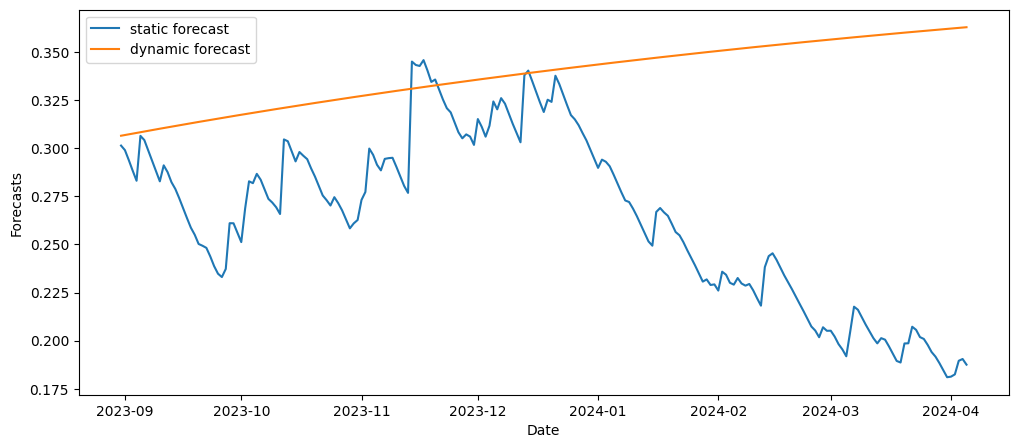

In [44]:
plt.figure(figsize=(12,5))
plt.plot(cvar_rjpy_stat, label="static forecast")
plt.plot(cvar_rjpy_dyn, label="dynamic forecast")

plt.xlabel("Date")
plt.ylabel("Forecasts")
plt.legend()
plt.show()

In [29]:
model_garch  = arch_model()
fitted_model  = model_garch.fit(last_obs="2023-08-30",disp="off")
print(fitted_model .summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                USD_AUD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -774.344
Distribution:                  Normal   AIC:                           1556.69
Method:            Maximum Likelihood   BIC:                           1575.78
                                        No. Observations:                  875
Date:                Mon, Apr 15 2024   Df Residuals:                      874
Time:                        22:26:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0203  1.917e-02      1.057      0.290 

In [33]:
import plotly.graph_objects as go

# Forecast the volatility
forecasts = fitted_model.forecast(horizon=len(test))#, start=train.index[-1])
forecasts_res = forecasts.variance.dropna()


cvar_rjpy_dyn = pd.DataFrame(
    data=forecasts_res.iloc[1].values,
    columns=["dynamic forecasting"],
    index=test.index,
)

plt.figure(1, dpi=600)
plt.plot(cvar_rjpy_stat, label="static forecast")
plt.plot(cvar_rjpy_dyn, label="dynamic forecast")

plt.xlabel("Date")
plt.ylabel("Forecasts")
plt.legend()
plt.show()

#predicted_volatility = np.sqrt(forecasts.variance.values[-1])
#
## Plot both predicted volatility and actual exchange rates
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=test.index, y=predicted_volatility, mode='lines', name='Predicted Volatility'))
#fig.add_trace(go.Scatter(x=test.index, y=test['USD_AUD'], mode='lines', name='Actual Exchange Rate'))
#
#fig.update_layout(title='Predicted Volatility and Actual Exchange Rates for USD_AUD',
#                  xaxis_title='Date',
#                  yaxis_title='Value',
#                  legend_title='Legend')
#fig.show()

In [ ]:
res = am.fit(last_obs="2016-08-03", disp="off")
forecasts = res.forecast(horizon=len(data_out_of_the_sample))
forecasts_res = forecasts.variance.dropna()

cvar_rjpy_dyn = pd.DataFrame(
    data=forecasts_res.iloc[1].values,
    columns=["dynamic forecasting"],
    index=data_out_of_the_sample.index,
)

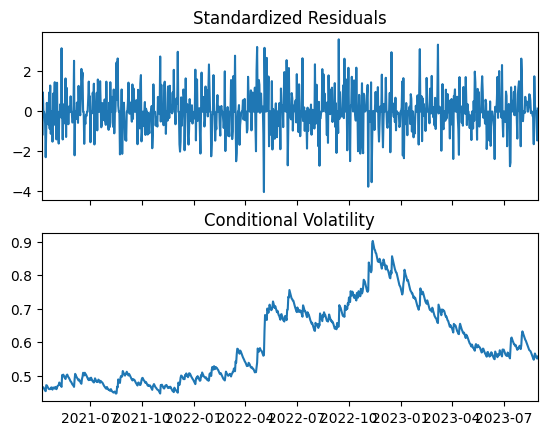

In [17]:
fig = res.plot()

In [19]:
# Forecast the next 10 days of volatility

forecasts = res.forecast(horizon=train_size)

# Print the mean and standard error of the forecasts

print(forecasts.mean)

print(forecasts.variance)

               h.001     h.002     h.003     h.004     h.005     h.006  \
Date                                                                     
2023-08-30  0.020367  0.020367  0.020367  0.020367  0.020367  0.020367   

               h.007     h.008     h.009     h.010  ...     h.867     h.868  \
Date                                                ...                       
2023-08-30  0.020367  0.020367  0.020367  0.020367  ...  0.020367  0.020367   

               h.869     h.870     h.871     h.872     h.873     h.874  \
Date                                                                     
2023-08-30  0.020367  0.020367  0.020367  0.020367  0.020367  0.020367   

               h.875     h.876  
Date                            
2023-08-30  0.020367  0.020367  

[1 rows x 876 columns]
              h.001     h.002    h.003     h.004     h.005     h.006  \
Date                                                                   
2023-08-30  0.30586  0.306226  0.30659  0.306952 

In [11]:
# Sampling
data_in_the_sample = data.loc[:"2023-06-02", "USD_AUD"]
data_out_of_the_sample = data.loc["2023-06-03":, "USD_AUD"]

#### USD_AUD Currency Exchange

In [13]:
# Defining the GARCH model on the in-sample data
am = arch_model(train["USD_AUD"], vol="Garch")  # Specifying p, q for GARCH(1,1)


In [14]:
# Initialize and fit the GARCH model on in-sample data
am = arch_model(data_in_the_sample, mean='Constant', vol='Garch', p=1, q=1)
res = am.fit(disp='off')

# Prepare to store forecasts
forecasts = []

# Manually create rolling one-step forecasts
for i in range(len(data_out_of_the_sample)):
    # Generate a forecast
    next_forecast = res.forecast(horizon=1, start=data_out_of_the_sample.index[i])
    # Store the forecasted variance
    if not next_forecast.variance.dropna().empty:
        forecasted_var = next_forecast.variance.dropna().iloc[0, 0]
        forecasts.append(forecasted_var)
    else:
        # Append None or np.nan if forecast cannot be generated
        forecasts.append(np.nan)

# Create a DataFrame with the forecasts
forecast_df = pd.DataFrame({
    'Date': data_out_of_the_sample.index,
    'Forecasted Variance': forecasts
})

# Display the results
print(forecast_df)

/home/dalopeza/.local/share/virtualenvs/estadistica-avanzada-_iX5znns/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00552. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


          Date  Forecasted Variance
0   2023-06-03                  NaN
1   2023-06-04                  NaN
2   2023-06-05                  NaN
3   2023-06-06                  NaN
4   2023-06-07                  NaN
..         ...                  ...
303 2024-04-01                  NaN
304 2024-04-02                  NaN
305 2024-04-03                  NaN
306 2024-04-04                  NaN
307 2024-04-05                  NaN

[308 rows x 2 columns]


In [15]:
cvar_rjpy_stat = {}
for date in data_out_of_the_sample.index:
    # Fit the model up to 'date' not including 'date'
    res = am.fit(last_obs=pd.Timestamp(date) - pd.Timedelta(days=1), disp="off")
    # Forecast the next day
    forecasts = res.forecast(horizon=1)
    # Since we forecast 1 day, we use iloc[0] to get that forecast
    forecasts_res = forecasts.variance.dropna()
    if not forecasts_res.empty:
        cvar_rjpy_stat[date] = forecasts_res.iloc[0]

cvar_rjpy_stat = pd.DataFrame(list(cvar_rjpy_stat.items()), columns=['Date', 'Forecasted Variance'])

# Print or inspect the DataFrame
print(cvar_rjpy_stat)

/home/dalopeza/.local/share/virtualenvs/estadistica-avanzada-_iX5znns/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005515. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/dalopeza/.local/share/virtualenvs/estadistica-avanzada-_iX5znns/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00552. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting re

          Date                                Forecasted Variance
0   2023-06-03  h.1    0.01706
Name: 2023-06-01 00:00:00, dtyp...
1   2023-06-04  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
2   2023-06-05  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
3   2023-06-06  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
4   2023-06-07  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
..         ...                                                ...
303 2024-04-01  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
304 2024-04-02  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
305 2024-04-03  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
306 2024-04-04  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...
307 2024-04-05  h.1    0.01616
Name: 2023-06-02 00:00:00, dtyp...

[308 rows x 2 columns]


/home/dalopeza/.local/share/virtualenvs/estadistica-avanzada-_iX5znns/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00552. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/dalopeza/.local/share/virtualenvs/estadistica-avanzada-_iX5znns/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00552. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting res

In [16]:

am = arch_model(train["USD_AUD"], vol="Garch")

In [17]:
cvar_rjpy_stat = {}
for date in data_out_of_the_sample.index:
    res = am.fit(last_obs=date, disp="off")
    forecasts = res.forecast(horizon=1)
    forecasts_res = forecasts.variance.dropna()
    cvar_rjpy_stat[date] = forecasts_res.iloc[1]

cvar_rjpy_stat = pd.DataFrame(cvar_rjpy_stat).T

AssertionError: 

In [ ]:

# Define the GARCH model
model = arch_model(train["USD_AUD"], vol='GARCH')

# Fit the model
fitted_model = model.fit()

# Forecast the test set
test_pred = fitted_model.forecast(horizon=len(test))
predicted_volatility = np.sqrt(test_pred.variance.dropna().values[-1])

# Ensure the index of predicted_volatility aligns with the test set
predicted_volatility = pd.Series(predicted_volatility, index=test.index)

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': test,
    'Predicted': predicted_volatility
})

# Plot using Plotly Express
fig = px.line(results_df, title='Actual vs Predicted Volatility')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Volatility')
fig.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test, predicted_volatility)
mae = mean_absolute_error(test, predicted_volatility)
mape = mean_absolute_percentage_error(test, predicted_volatility)

print('MSE:', mse)
print('MAE:', mae)
print('MAPE:', mape)

/home/dalopeza/.local/share/virtualenvs/estadistica-avanzada-_iX5znns/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




MSE: 1.6874974154229538
MAE: 1.2989650088729885
MAPE: 0.9589942910871211
